In [47]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas
import importlib
#from toggle_cell import hide_cell 
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)
import root_pandas,glob

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

plt.rcParams['savefig.bbox']='tight'
import misc_util
importlib.reload(misc_util)
import gc

import ROOT
import collections
pdg = ROOT.TDatabasePDG()

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

Warning in <TDatabasePDG::TDatabasePDG>: object already instantiated


In [48]:
#produce plots similar to those in NC-DIS paper https://journals.aps.org/prd/pdf/10.1103/PhysRevD.102.074015

In [84]:
#df_all = root_pandas.read_root("../CC_DIS_EIC_1.5M_all.root")
#df_all = root_pandas.read_root("../CC_DIS_EIC_test_10k.root")

df_all = root_pandas.read_root("../athena_tuples_test.root")

In [85]:
print(df_all.memory_usage().sum()/1024**3, "GB")
ints = df_all.select_dtypes(include=['int64']).columns.tolist()
df_all[ints] = df_all[ints].astype('int16')
print(df_all.memory_usage().sum()/1024**3, "GB")
#for col in "Hadron_i Jet_i Neutrino_PID Quark_PID GenJet_NCharged GenJet_NNeutrals Jet_NCharged Jet_NNeutrals".split():
    

0.045350685715675354 GB
0.045350685715675354 GB


In [86]:
if not "Hadron_i" in df_all.columns:
    df_all['Hadron_i'] = df_all.eval("Jet_i-Jet_i")
df_jets = df_all.query('(Jet_PT > 0 or GenJet_PT>0) and Hadron_i == 0')
df_rg = df_all.query('Jet_E > 0 and GenJet_E>0 and Hadron_i == 0')
df_nu = df_all.query("Jet_i == 0 and Hadron_i == 0") #just neutrinos.  
df_hadrons = df_all.query("Hadron_P>0 or Hadron_E>0")
print([len(a) for a in (df_all,df_jets,df_rg,df_nu,df_hadrons)])
del df_all

[63240, 9307, 5838, 10000, 58842]


<ipython-input-87-ec6ee20ef86d>:13: RuntimeWarning: invalid value encountered in true_divide
  axs[1].errorbar(x,r/g,drat, color='g',marker='o', label='gen.')


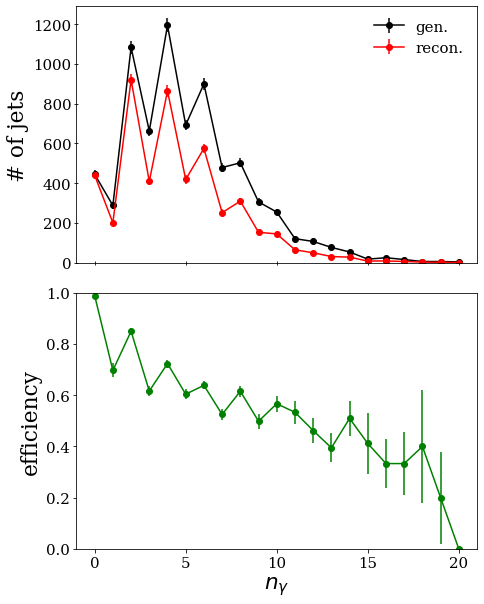

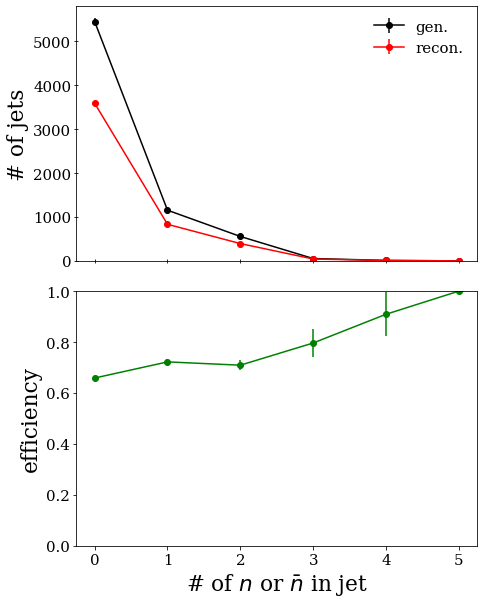

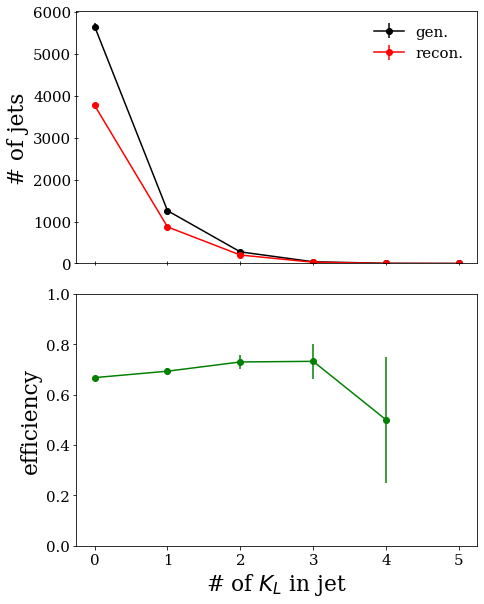

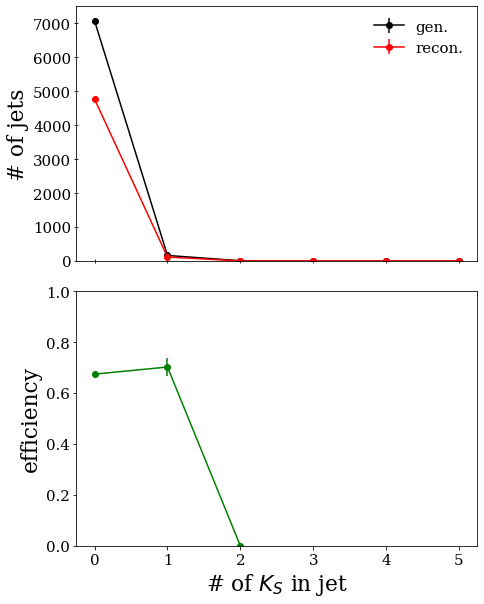

In [87]:
def efficiency_vs(xvar,xlabel,bins = dict(bins=np.linspace(-0.5,20.5,22))):
    df = df_jets.query('GenJet_PT>10 and GenJet_size ==1')
    fig,axs = plt.subplots(2,1, figsize=(7,14/golden),sharex='all')
    r,x = np.histogram(df.query('Jet_PT>0').eval(xvar),**bins)
    g,x = np.histogram(df.eval(xvar),**bins)
    x = (x[:-1]+x[1:])/2
    axs[0].errorbar(x,g,np.sqrt(g), color='k',marker='o', label='gen.')
    axs[0].errorbar(x,r,np.sqrt(r), color='r',marker='o', label='recon.')
    axs[0].legend(framealpha=0)
    axs[0].set_ylabel('# of jets')
    axs[0].set_ylim(0)
    drat = np.sqrt(r*(g-r))/(g**(3/2)+.01)
    axs[1].errorbar(x,r/g,drat, color='g',marker='o', label='gen.')
    axs[1].set_ylabel('efficiency')
    axs[1].set_ylim(0, 1)
    #axs[0].set_xlabel('# of neutral hadrons in jet ')
    axs[1].set_xlabel(xlabel)
    fig.tight_layout()
    axs[0].tick_params(bottom=True,direction='inout')

#efficiency_vs("GenJet_NNeutrals","# of neutral constituents in jet ")
#plt.savefig('images/efficiency_vs_nneutral.png')
efficiency_vs("GenJet_n_22","$n_{\\gamma}$")
plt.savefig('images/efficiency_vs_ngamma.png')
efficiency_vs("GenJet_n_2112+GenJet_n_m2112",
              "# of $n$ or $\\bar n$ in jet ",
             bins = dict(bins=np.linspace(-0.5,5.5,7)))
plt.savefig('images/efficiency_vs_n_nbar.png')
efficiency_vs("GenJet_n_130",
              "# of $K_L$ in jet ",
             bins = dict(bins=np.linspace(-0.5,5.5,7)))
plt.savefig('images/efficiency_vs_KL.png')
efficiency_vs("GenJet_n_310",
              "# of $K_S$ in jet ",
             bins = dict(bins=np.linspace(-0.5,5.5,7)))
plt.savefig('images/efficiency_vs_KS.png')

In [80]:
pids = [col.replace("GenJet_n_","")  for col in df_jets.columns if "GenJet_n_" in col]
for i in pids:
    print(i,np.mean(df_jets.query("GenJet_n_22>5").eval(f"GenJet_n_{i}")),np.mean(df_jets.eval(f"GenJet_n_{i}")))

22 8.178666666666667 4.7187063500590956
211 2.165037037037037 1.8951326958203503
m211 2.566222222222222 2.2936499409046953
2212 0.13125925925925927 0.15439991404319328
m2212 0.112 0.1353819705597937
2112 0.14992592592592593 0.19447727516922747
m2112 0.10488888888888889 0.13398517245084346
130 0.24207407407407408 0.2603416783066509
310 0.014814814814814815 0.020092403567207477
321 0.22251851851851853 0.24304287095734395
m321 0.22874074074074074 0.24605135919200602
other 0.09748148148148149 0.08219619641130332


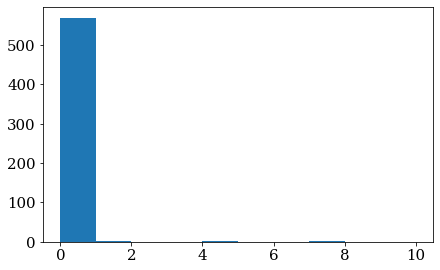

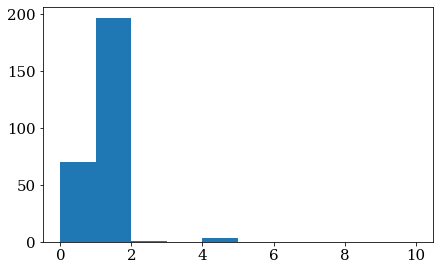

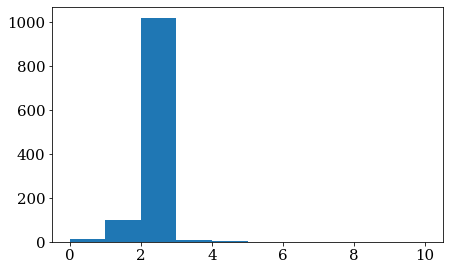

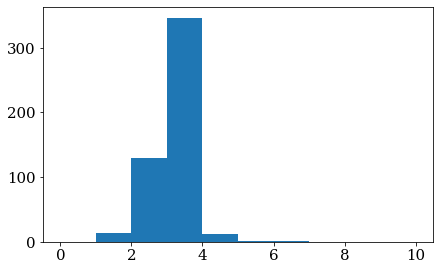

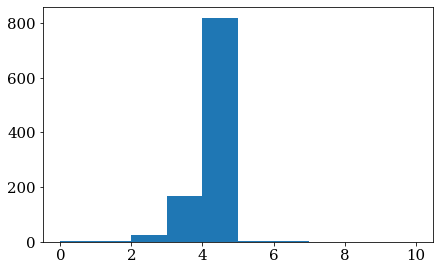

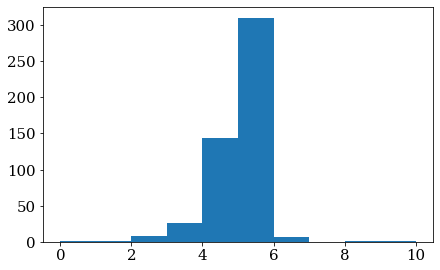

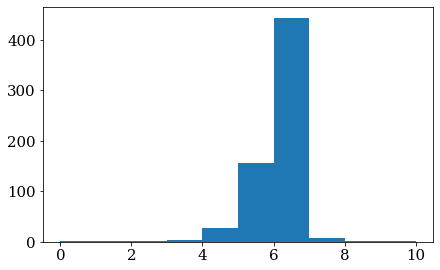

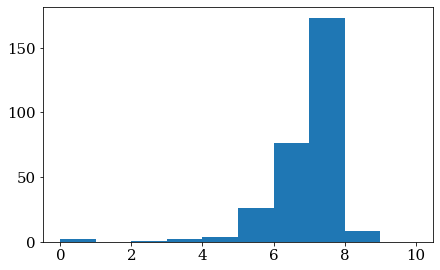

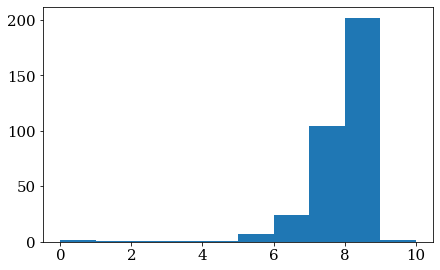

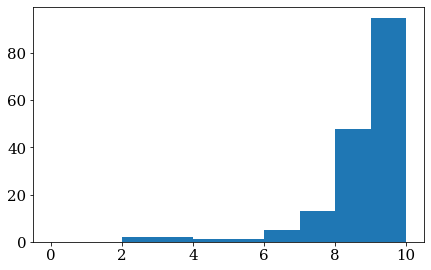

In [81]:
for i in range(10):
    df = df_jets.query(f"GenJet_n_22=={i} and Jet_PT>0 and GenJet_PT>0")
    plt.hist(df.eval(f"Jet_n_22"),bins=range(11))
    plt.show()



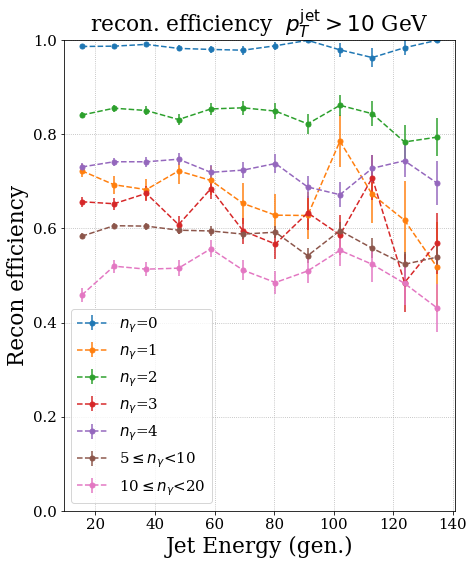

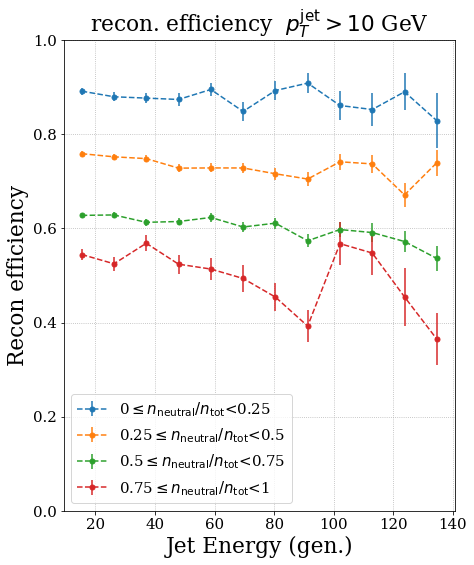

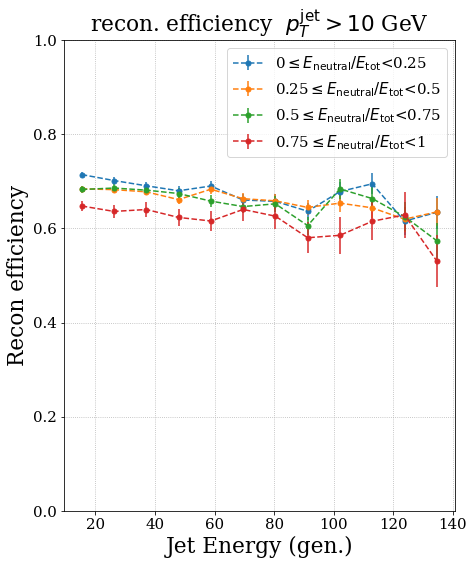

In [75]:

def efficiency_plot(xvar = 'GenJet_NNeutrals',
            xlbl = '$n_{\\mathrm{neutral}}$',
        partitions = [0,1,2,4, 20]):
    df = df_jets
    fig,axs = plt.subplots(1,1, figsize=(7,14/golden),sharex='all')
    for j in range(len(partitions)-1):
        x,y,dy = [],[],[]
        lbl = f'{partitions[j]}$\leq${xlbl}<{partitions[j+1]}'
        dfj = df.query(f"GenJet_PT>10 and {xvar} >= {partitions[j]} and {xvar} < {partitions[j+1]}")
        v = dfj.eval(xvar)[:1000]
        if np.std(v) == 0:
            mean = np.mean(v)
            if mean%1 == 0:
                mean = str(int(mean))
            lbl = f"{xlbl}={mean}"
        E = np.linspace(10, 140,(140-15)//10+1)
        for i in range(len(E)-1):

            df_slice = dfj.query(f"GenJet_E>{E[i]} and GenJet_E<{E[i+1]}")

            n = len(df_slice.query("Jet_PT>0")) #numerator: count gen jets that have a recon jet
            d = len(df_slice) #denominator:  count just the gen jets.  
            if(n>5):
                x.append((E[i]+E[i+1])/2)
                y.append(n/d)
                dy.append(np.sqrt(n*(d-n))/max(d**(3/2),1))
            del df_slice
        plt.errorbar(x,y,dy,linestyle='--',marker='o',markersize=5, label=lbl)

    plt.gca().legend(ncol=1)
    plt.gca().set_ylabel("Recon efficiency")
    plt.gca().set_xlabel("Jet Energy (gen.)")
    plt.grid(linestyle=':')
    plt.gca().set_title("recon. efficiency  $p^{\\mathrm{jet}}_T>10$ GeV")
    plt.gca().set_ylim(0,1)

efficiency_plot(xvar = 'GenJet_n_22',
            xlbl = '$n_{\\gamma}$',
        partitions = [0,1,2,3,4,5,10,20])
plt.savefig("images/Egen_vs_efficiency_nneutral.png",bbox_inches='tight')
plt.show()

efficiency_plot(xvar = 'GenJet_NNeutrals/(GenJet_NNeutrals+GenJet_NCharged)',
            xlbl = '$n_{\\mathrm{neutral}}/n_{\\mathrm{tot}}$',
        partitions = [0,0.25,0.5,0.75, 1])
plt.savefig("images/Egen_vs_efficiency_nneutral_frac.png",bbox_inches='tight')
plt.show()

efficiency_plot(xvar = 'GenJet_NeutralEnergyFraction',
            xlbl = '$E_{\\mathrm{neutral}}/E_{\\mathrm{tot}}$',
        partitions = [0,0.25,0.5,0.75, 1])
plt.savefig("images/Egen_vs_efficiency_Eneutral_frac.png",bbox_inches='tight')
plt.show()

# now for diagnostic plots

(array([14928., 31714., 26508., 22593., 19396., 16658., 14402., 13002.,
        11127., 10206.,  9071.,  8202.,  7561.,  6772.,  5990.,  5666.,
         5140.,  4806.,  4409.,  4011.,  3739.,  3526.,  3283.,  3023.,
         2925.,  2627.,  2549.,  2341.,  2301.,  2074.,  1925.,  1901.,
         1791.,  1693.,  1624.,  1513.,  1405.,  1427.,  1248.,  1247.,
         1155.,  1153.,  1072.,  1047.,   983.,   986.,   924.,   900.,
          828.,   822.,   778.,   775.,   690.,   713.,   673.,   605.,
          639.,   627.,   566.,   581.,   501.,   496.,   505.,   520.,
          442.,   429.,   441.,   438.,   391.,   418.,   392.,   368.,
          371.,   312.,   364.,   313.,   322.,   312.,   298.,   261.,
          301.,   270.,   263.,   261.,   245.,   255.,   221.,   235.,
          197.,   229.,   218.,   210.,   205.,   194.,   187.,   193.,
          202.,   189.,   176.,   190.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4, 

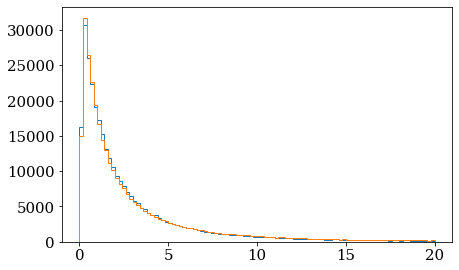

In [70]:
plt.hist(df_hadrons.query('Hadron_Charge==0').Hadron_E,histtype='step',bins=100, range=(0,20))
plt.hist(df_hadrons.query('Hadron_Charge==0').GenHadron_E,histtype='step',bins=100, range=(0,20))

In [ ]:
neuts = df_hadrons.query('Hadron_Charge==0')
plt.hist(neuts.eval('GenHadron_E-Hadron_E'),histtype='step',bins=100,range=(-10,10))
plt.show()
plt.hist(neuts.eval('Hadron_E'),histtype='step',bins=100, range=(0,1))
plt.hist(neuts.eval('GenHadron_E'),histtype='step',bins=100, range=(0,1))
plt.show()

In [27]:
print(set(neuts.eval('GenHadron_PID')))
print(len(neuts.query('GenHadron_PID ==22'))/len(neuts))

{130, -3322, 11, 13, -3312, 22, 3222, 2212, 3112, -211, 3122, 310, -321, 2112, -2112, 321, -3122, 211, -3112, -2212, -3222, 3312, -13, -11, 3322}
0.7559152235854334


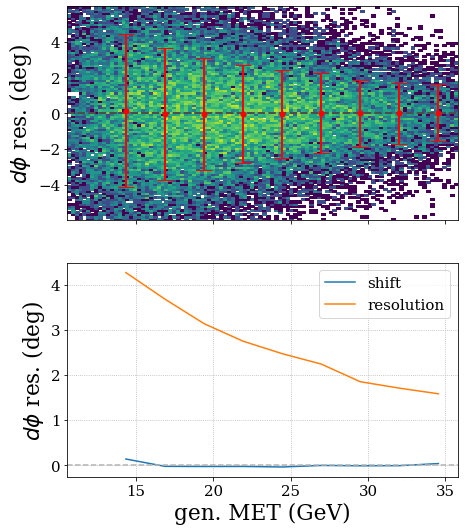

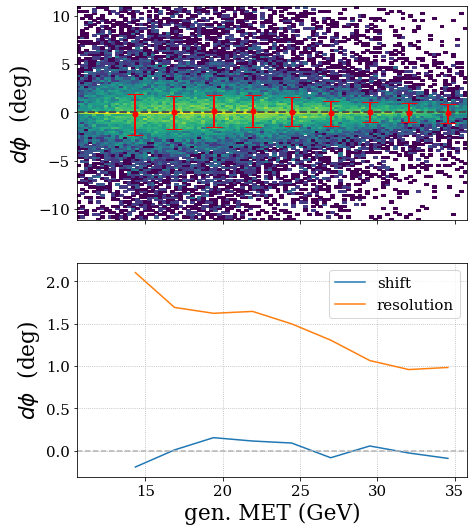

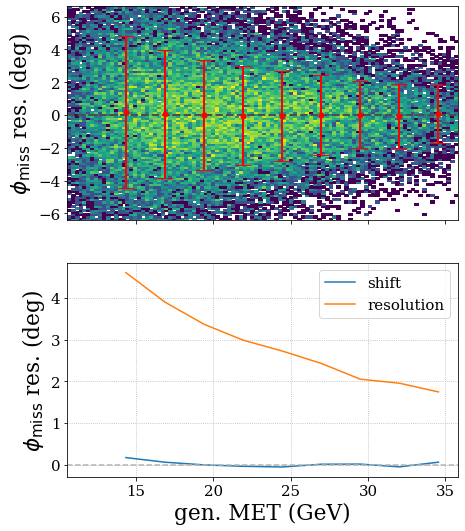

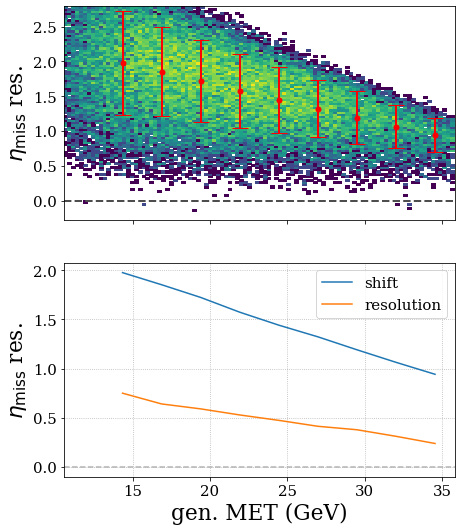

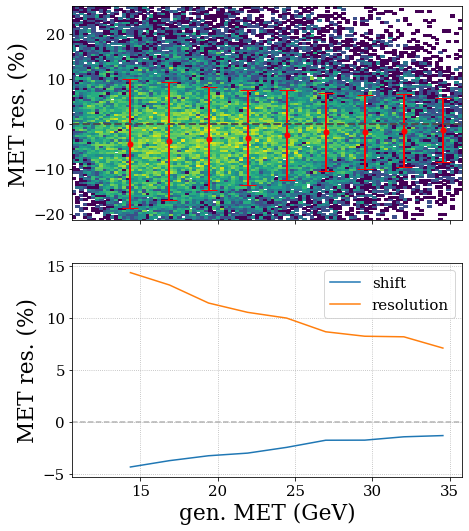

In [264]:
def resolution_plot(yexpr, ylbl,xlbl="gen. MET (GeV)", xexpr="GenMissingET_MET", condition = None):
    df = df_jets.query("Jet_PT>10 and GenJet_PT>10")
    if condition != None:
        df = df.query(condition)
    fig,axs = plt.subplots(2,1, figsize=(7,14/golden),sharex='all')
    plt.sca(axs[0])

    import matplotlib as mpl
    xv = df.eval(xexpr)
    yv = df.eval(yexpr)
    
    mn,mx = xv.quantile(.03),xv.quantile(.97)
    if mn > 0 and mn < mx*.12:
        mn = 0
    
    ymn = yv.quantile(.05)
    ymx = yv.quantile(.95)
    
    if(ymn>-.1*ymx):
        ymn = -.1*ymx
    
    plt.hist2d(xv,yv, 
               bins=100,range=([mn,mx],[ymn,ymx]), norm=mpl.colors.LogNorm())
    plt.gca().set_ylabel(ylbl)

    plt.axhline(0,linestyle='--',color='0.3',linewidth=2)
    x,y,dy = [],[],[]
    
    nbins = 10
    
    for i in range(1,nbins):
        
        df_slice = df_rg.query("%s>%s and %s<%s" \
                               %(xexpr,i*(mx-mn)/nbins+mn,xexpr,(i+1)*(mx-mn)/nbins+mn))
        if len(df_slice)<3:
            continue
        x.append((i+0.5)*(mx-mn)/nbins+mn)
        mean,std = misc_util.getmeanstd(df_slice,yexpr)
        y.append(mean)
        dy.append(std)
        del df_slice
    plt.errorbar(x,y,dy, color='r',linestyle='',marker='o',markersize=5,linewidth=2,capsize=8)
    gc.collect()

    plt.sca(axs[1])

    plt.plot(x,y,label='shift')
    plt.plot(x,dy,label='resolution')
    plt.axhline(0,linestyle='--',color='0.7')
    plt.legend()
    plt.gca().set_ylabel(ylbl)

    plt.gca().set_xlabel(xlbl)
    plt.grid(linestyle=':')
    del df
phistr = lambda expr : "(XXX - 2*3.141592653589793*(XXX>3.141592653589793) + 2*3.141592653589793*(XXX<-3.141592653589793))*180/3.141592653589793".replace("XXX",expr)


resolution_plot(phistr("MissingET_Phi-GenMissingET_Phi-Jet_Phi+GenJet_Phi"), "$d\\phi$ res. (deg)")
plt.savefig("images/MET_vs_dphi_resolution.png")


resolution_plot(phistr("MissingET_Phi-Jet_Phi+3.141592653589793"), "$d\\phi$  (deg)")
plt.savefig("images/MET_vs_dphi_recon.png")


resolution_plot(phistr("MissingET_Phi-GenMissingET_Phi"), "$\\phi_{\\mathrm{miss}}$ res. (deg)")
plt.savefig("images/MET_vs_ETphi_resolution.png")

resolution_plot("MissingET_Eta-GenMissingET_Eta", "$\\eta_{\\mathrm{miss}}$ res.")
plt.savefig("images/MET_vs_ETeta_resolution.png")

resolution_plot("(MissingET_MET-GenMissingET_MET)*100/GenMissingET_MET", "MET res. (%)")
plt.savefig("images/MET_vs_MET_resolution.png")

#resolution_plot(phistr("Jet_Phi-GenJet_Phi"), "$\\phi_{\\mathrm{jet}}$ res. (deg)","gen. $E_{\\mathrm{jet}}$ (GeV)", "GenJet_E")
#plt.savefig("images/Ejet_vs_jetphi_resolution.png")

#resolution_plot("Jet_Eta-GenJet_Eta", "$\\eta_{\\mathrm{jet}}$ res.","gen. $E_{\\mathrm{jet}}$ (GeV)", "GenJet_E")
#plt.savefig("images/Ejet_vs_jeteta_resolution.png")

#resolution_plot("(Jet_E-GenJet_E)*100/GenJet_E", "$E_{\\mathrm{jet}}$ res. (%)","gen. $E_{\\mathrm{jet}}$ (GeV)", "GenJet_E")
#plt.savefig("images/Ejet_vs_jetE_resolution.png")

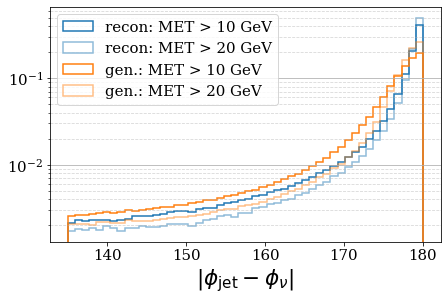

In [52]:
df = df_jets.query("Jet_PT>0")
args = dict(bins =50,histtype='step',density=True,range=(135,180),linewidth=1.5)
expr = "abs(" + phistr("MissingET_Phi-Jet_Phi")+")"
plt.hist(df.query("MissingET_MET>10").eval(expr),**args,label='recon: MET > 10 GeV',color='tab:blue')
plt.hist(df.query("MissingET_MET>20").eval(expr),**args,label='recon: MET > 20 GeV',color='tab:blue',alpha=0.5)

df = df_jets.query("GenJet_PT>0")

expr = "abs(" + phistr("GenMissingET_Phi-GenJet_Phi")+")"
plt.hist(df.query("GenMissingET_MET>10").eval(expr),**args,label='gen.: MET > 10 GeV',color='tab:orange')
plt.hist(df.query("GenMissingET_MET>20").eval(expr),**args,label='gen.: MET > 20 GeV',color='tab:orange',alpha=0.5)
plt.legend(loc='upper left')

plt.gca().set_xlabel("$|\\phi_{\\mathrm{jet}}-\\phi_{\\nu}|$")
plt.gca().set_yscale('log')
plt.savefig("images/deltaphi.png")
plt.grid(which='major',axis='y')
plt.grid(b=True,which='minor',linestyle='--',alpha=0.5,axis='y')
plt.savefig("images/deltaphi.png")
plt.show()


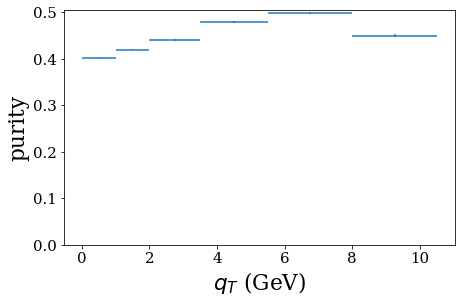

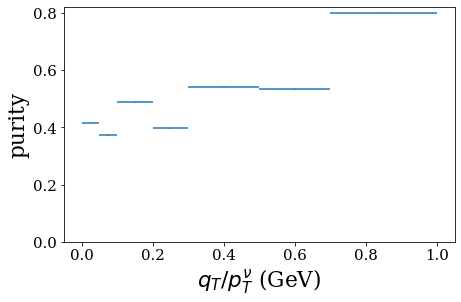

In [49]:
def purity_plot(df, expr,genExpr,partitions):
    xs = []
    ys = []
    dys = []
    dxs = []
    for i in range(len(partitions)-1):
        x=(partitions[i]+partitions[i+1])/2
        dx = (partitions[i+1]-partitions[i])/2
        num = len(df.query(f"{expr}>={partitions[i]} and {expr}<{partitions[i+1]} and {genExpr}>={partitions[i]} and {genExpr}<{partitions[i+1]}"))
        denom = len(df.query(f"{expr}>={partitions[i]} and {expr}<{partitions[i+1]}"))
        if denom == 0:
            continue
        y =num/denom
        dy = np.sqrt(((denom-num)*num)/denom**3)
        
        xs.append(x)
        ys.append(y)
        dys.append(dy)
        dxs.append(dx)
    plt.errorbar(xs,ys,dys,dxs,linestyle='')
    
    
purity_plot(df_rg.query("Jet_PT>0"),"qT","Gen_qT",[0,1,2,3.5,5.5,8,10.5])
plt.gca().set_xlabel("$q_T$ (GeV)")
plt.gca().set_ylabel("purity")   
plt.gca().set_ylim(0)
plt.savefig("images/purity_qT.png")
plt.show()
purity_plot(df_rg.query("Jet_PT>0"),"qT/MissingET_MET","Gen_qT/GenMissingET_MET",[0,0.05,0.1,0.2,0.3,0.5,0.7,1])
plt.gca().set_xlabel("$q_T/p^\\nu_T$ (GeV)")
plt.gca().set_ylabel("purity")   
plt.gca().set_ylim(0)
plt.savefig("images/purity_qToverptnu.png")

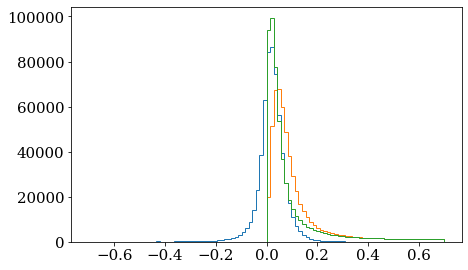

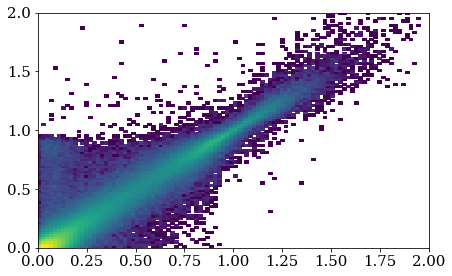

In [46]:
df = df_rg.query("Neutrino_PT>15")
expr1 = "sqrt(GenMissingET_MET**2+GenJet_PT**2+2*GenMissingET_MET*GenJet_PT*cos(GenJet_Phi-GenMissingET_Phi))/GenMissingET_MET"
expr2 = expr1.replace("Gen","")
plt.hist(df.eval(expr1+ "-("+expr2+")"), bins=100, range=(-.7,.7),histtype='step')
plt.hist(df.eval(expr1), bins=100, range=(-.7,.7),histtype='step')
plt.hist(df.eval(expr2), bins=100, range=(-.7,.7),histtype='step')
plt.show()
plt.hist2d(df.eval(expr1),df.eval(expr2),range=((0,2),(0,2)),bins=100,norm=mpl.colors.LogNorm())
plt.show()

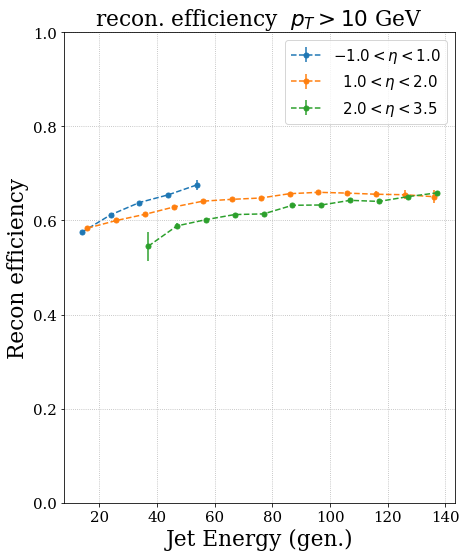

In [139]:
#etanumin,etanumax=-3.5,3.5

df = df_jets
fig,axs = plt.subplots(1,1, figsize=(7,14/golden),sharex='all')
for etarange,lbl in [(-1,1), "$-1.0<\\eta<1.0$"],[(1,2), "  $1.0<\\eta<2.0$"],[(2,3.5), "  $2.0<\\eta<3.5$"]  :
    x,y,dy = [],[],[]
    for i in range(1,14):
        
        df_slice = df.query("GenJet_E>%s and GenJet_E<%s and GenJet_Eta>%s and GenJet_Eta<%s and GenJet_PT>10" %(i*10,(i+1)*10,*etarange))
        
        n = len(df_slice.query("Jet_PT>0")) #numerator: count gen jets that have a recon jet
        d = len(df_slice) #denominator:  count just the gen jets.  
        if(n>5):
            x.append(i*10+5)
            y.append(n/d)
            dy.append(np.sqrt(n*(d-n))/max(d**(3/2),1))
        del df_slice
    plt.errorbar(np.add(x,etarange[0]),y,dy,linestyle='--',marker='o',markersize=5, label=lbl)

plt.gca().legend(ncol=1)
plt.gca().set_ylabel("Recon efficiency")
plt.gca().set_xlabel("Jet Energy (gen.)")
plt.grid(linestyle=':')
plt.gca().set_title("recon. efficiency  $p_T>10$ GeV")
plt.gca().set_ylim(0,1)

plt.savefig("images/Egen_vs_efficiency_eta.png",bbox_inches='tight')
plt.show()

In [140]:
print(list(df_jets.columns))

['Jet_PT', 'Jet_Eta', 'Jet_Phi', 'Jet_Mass', 'Jet_DeltaEta', 'Jet_DeltaPhi', 'Jet_Flavor', 'Jet_FlavorAlgo', 'Jet_FlavorPhys', 'Jet_BTag', 'Jet_BTagAlgo', 'Jet_BTagPhys', 'Jet_TauTag', 'Jet_TauWeight', 'Jet_Charge', 'Jet_EhadOverEem', 'Jet_NCharged', 'Jet_NNeutrals', 'Jet_NeutralEnergyFraction', 'Jet_ChargedEnergyFraction', 'Jet_NSubJetsTrimmed', 'Jet_NSubJetsPruned', 'Jet_NSubJetsSoftDropped', 'GenJet_PT', 'GenJet_Eta', 'GenJet_Phi', 'GenJet_Mass', 'GenJet_DeltaEta', 'GenJet_DeltaPhi', 'GenJet_Flavor', 'GenJet_FlavorAlgo', 'GenJet_FlavorPhys', 'GenJet_BTag', 'GenJet_BTagAlgo', 'GenJet_BTagPhys', 'GenJet_TauTag', 'GenJet_TauWeight', 'GenJet_Charge', 'GenJet_EhadOverEem', 'GenJet_NCharged', 'GenJet_NNeutrals', 'GenJet_NeutralEnergyFraction', 'GenJet_ChargedEnergyFraction', 'GenJet_NSubJetsTrimmed', 'GenJet_NSubJetsPruned', 'GenJet_NSubJetsSoftDropped', 'Neutrino_PID', 'Neutrino_Status', 'Neutrino_IsPU', 'Neutrino_M1', 'Neutrino_M2', 'Neutrino_D1', 'Neutrino_D2', 'Neutrino_Mass', 'Neutri

In [82]:
print(df_jets.columns)

Index(['Jet_PT', 'Jet_Eta', 'Jet_Phi', 'Jet_Mass', 'Jet_DeltaEta',
       'Jet_DeltaPhi', 'GenJet_PT', 'GenJet_Eta', 'GenJet_Phi', 'GenJet_Mass',
       'GenJet_DeltaEta', 'GenJet_DeltaPhi', 'Neutrino_PID', 'Neutrino_Status',
       'Neutrino_E', 'Neutrino_Px', 'Neutrino_Py', 'Neutrino_Pz',
       'Neutrino_PT', 'Neutrino_Eta', 'Quark_PID', 'Quark_Status', 'Quark_E',
       'Quark_Px', 'Quark_Py', 'Quark_Pz', 'Quark_PT', 'Quark_Eta',
       'MissingET_MET', 'MissingET_Eta', 'MissingET_Phi', 'GenMissingET_MET',
       'GenMissingET_Eta', 'GenMissingET_Phi', 'Event_Number', 'Gen_W2',
       'Gen_x', 'Gen_y', 'Gen_Q2', 'Hadron_PID', 'Hadron_Charge', 'Hadron_P',
       'Hadron_PT', 'Hadron_Eta', 'Hadron_Phi', 'GenHadron_PID',
       'GenHadron_Charge', 'GenHadron_P', 'GenHadron_PT', 'GenHadron_Eta',
       'GenHadron_Phi', 'Hadron_i', 'Jet_i', 'JB_MET', 'JB_Eta', 'JB_Phi',
       'JB_Q2', 'JB_x', 'JB_y', 'Jet_E', 'GenJet_E', 'Hadron_Px', 'Hadron_Py',
       'Hadron_Pz', 'GenHadron_Px', 'Ge

<ipython-input-54-348a23df6d48>:17: RuntimeWarning: invalid value encountered in true_divide
  pc = plt.pcolor(n/d)


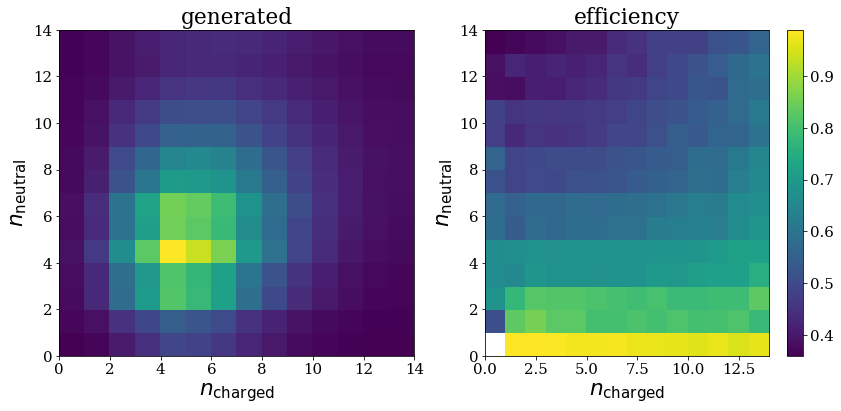

In [54]:
df = df_jets.query('GenJet_PT>10')
mx = 14
bins = mx
binning = dict(bins=mx,range=((0,mx),(0,mx)))
recon = df.query('Jet_PT>0')
n,x,y = np.histogram2d(recon.GenJet_NNeutrals,recon.GenJet_NCharged,**binning)
d,x,y = np.histogram2d(df.GenJet_NNeutrals,df.GenJet_NCharged,**binning)
fig,axs= plt.subplots(1,2,figsize=(14,6))

plt.sca(axs[0])
pc = plt.pcolor(d)
plt.gca().set_title('generated')
plt.gca().set_ylabel('$n_{\\mathrm{neutral}}$')
plt.gca().set_xlabel('$n_{\\mathrm{charged}}$')

plt.sca(axs[1])
pc = plt.pcolor(n/d)
plt.gca().set_title('efficiency')
plt.gca().set_ylabel('$n_{\\mathrm{neutral}}$')
plt.gca().set_xlabel('$n_{\\mathrm{charged}}$')

cbar = plt.colorbar(pc)
#help(cbar)
del recon
#np.histogram2d(df.GenJet_NNeutral,df.GenJet_NCharged,**binning)

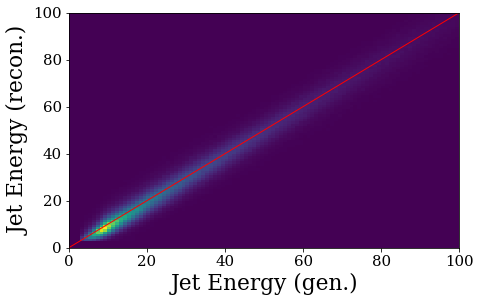

In [9]:

plt.hist2d(df_rg.GenJet_PT*np.cosh(df_rg.GenJet_Eta),df_rg.Jet_PT*np.cosh(df_rg.Jet_Eta), bins=100,range=([0,100],)*2)
plt.gca().set_xlabel("Jet Energy (gen.)")
plt.gca().set_ylabel("Jet Energy (recon.)")
plt.plot((0,100),(0,100),color='r',linewidth=1)
plt.savefig("images/Erecon_vs_Egen.png",bbox_inches='tight')
plt.show()

In [ ]:
fig,axs = plt.subplots(2,1, figsize=(7,14/golden),sharex='all')
plt.sca(axs[0])


df = df_jets.query("GenJet_Mass>0.05")
df_rg = df.query("Jet_PT*GenJet_PT>0")
import matplotlib as mpl
plt.hist2d(df_rg.eval("GenJet_E"),df_rg.eval("(Jet_E-GenJet_E)*100/GenJet_E"), 
           bins=100,range=([0,150],[-30,30]), norm=mpl.colors.LogNorm())
plt.gca().set_ylabel("jet energy res. (%)")

plt.axhline(0,linestyle='--',color='0.3',linewidth=2)
x,y,dy = [],[],[]
for i in range(1,14):
    df_slice = df_rg.query("GenJet_E>%s and GenJet_E<%s" %(i*10,(i+1)*10))
    x.append(i*10+5)
    q = df_slice.eval("(Jet_E-GenJet_E)*100/GenJet_E")
    y.append(np.mean(q))
    dy.append(np.std(q))
plt.errorbar(x,y,dy, color='r',linestyle='',marker='o',markersize=5)


plt.sca(axs[1])

plt.plot(x,y,label='jet energy scale')
plt.plot(x,dy,label='jet energy res.')
plt.axhline(0,linestyle='--',color='0.7')
plt.legend()
plt.gca().set_ylabel("jet energy res. (%)")

plt.gca().set_xlabel("Jet Energy (gen.)")
plt.grid(linestyle=':')

plt.savefig("images/Egen_vs_resolution.png")

In [177]:
10, 275

(array([ 2481.,  7039.,  9269., 10852., 11255., 11719., 11995., 12255.,
        12159., 12360., 12511., 12545., 12445., 12554., 12428., 12342.,
        12184., 12260., 12255., 12185., 12000., 12217., 11905., 11730.,
        11989., 11805., 11718., 11775., 11753., 11560., 11428., 11134.,
        11360., 11255., 11205., 10963., 11001., 10925., 10913., 10748.,
        10694., 10657., 10445., 10705., 10529., 10360., 10278., 10250.,
        10276., 10196., 10000., 10081.,  9869., 10165.,  9833.,  9828.,
         9612.,  9503.,  9442.,  9470.,  9304.,  9420.,  9401.,  9335.,
         9246.,  9208.,  9173.,  8964.,  9067.,  8960.,  8969.,  8853.,
         8837.,  8796.,  8746.,  8673.,  8787.,  8736.,  8653.,  8546.,
         8444.,  8579.,  8454.,  8532.,  8275.,  8254.,  8213.,  8294.,
         8205.,  8105.,  8111.,  8151.,  8163.,  8067.,  7930.,  7978.,
         7859.,  7996.,  8008.,  8038.]),
 array([0.00593436, 0.01587498, 0.0258156 , 0.03575622, 0.04569684,
        0.05563746, 0.0655

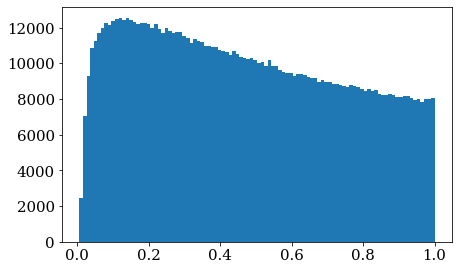

In [18]:
list(df_nu.columns)

['Jet_PT',
 'Jet_Eta',
 'Jet_Phi',
 'Jet_Mass',
 'Jet_DeltaEta',
 'Jet_DeltaPhi',
 'Jet_NCharged',
 'Jet_NNeutrals',
 'Jet_NeutralEnergyFraction',
 'Jet_ChargedEnergyFraction',
 'GenJet_PT',
 'GenJet_Eta',
 'GenJet_Phi',
 'GenJet_Mass',
 'GenJet_DeltaEta',
 'GenJet_DeltaPhi',
 'GenJet_NCharged',
 'GenJet_NNeutrals',
 'GenJet_NeutralEnergyFraction',
 'GenJet_ChargedEnergyFraction',
 'Neutrino_PID',
 'Neutrino_Status',
 'Neutrino_E',
 'Neutrino_Px',
 'Neutrino_Py',
 'Neutrino_Pz',
 'Neutrino_PT',
 'Neutrino_Eta',
 'Quark_PID',
 'Quark_Status',
 'Quark_E',
 'Quark_Px',
 'Quark_Py',
 'Quark_Pz',
 'Quark_PT',
 'Quark_Eta',
 'MissingET_MET',
 'MissingET_Eta',
 'MissingET_Phi',
 'GenMissingET_MET',
 'GenMissingET_Eta',
 'GenMissingET_Phi',
 'Event_Number',
 'Gen_W2',
 'Gen_x',
 'Gen_y',
 'Gen_Q2',
 'Hadron_PID',
 'Hadron_Charge',
 'Hadron_P',
 'Hadron_PT',
 'Hadron_Eta',
 'Hadron_Phi',
 'Hadron_E',
 'Hadron_ET',
 'Hadron_Eem',
 'Hadron_Ehad',
 'GenHadron_PID',
 'GenHadron_Charge',
 'GenHadron

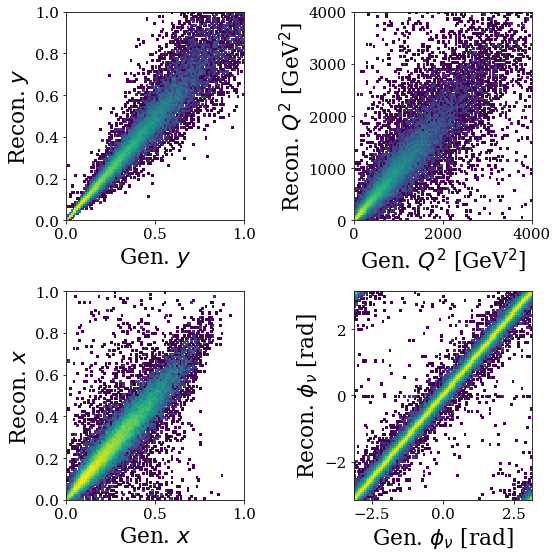

In [28]:
fig,axs = plt.subplots(2,2, figsize=(8,8))
plt.sca(axs[0][0])
plt.hist2d(df_nu.Gen_y,df_nu.JB_y,norm=mpl.colors.LogNorm(),bins=100, range=((0,1),(0,1)))
plt.gca().set_ylabel("Recon. $y$")
plt.gca().set_xlabel("Gen. $y$")
plt.sca(axs[0][1])
plt.hist2d(df_nu.Gen_Q2,df_nu.JB_Q2,norm=mpl.colors.LogNorm(),bins=100, range=((-1,4000),(-1,4000)))
plt.gca().set_ylabel("Recon. $Q^2$ [GeV$^2$]")
plt.gca().set_xlabel("Gen. $Q^2$ [GeV$^2$]")
plt.sca(axs[1][0])
plt.hist2d(df_nu.Gen_x,df_nu.JB_x,norm=mpl.colors.LogNorm(),bins=100, range=((0,1),(0,1)))
plt.gca().set_ylabel("Recon. $x$")
plt.gca().set_xlabel("Gen. $x$")
plt.sca(axs[1][1])
plt.hist2d(df_nu.GenMissingET_Phi-np.pi*(df_nu.GenMissingET_Phi>0)+np.pi*(df_nu.GenMissingET_Phi<0),df_nu.JB_Phi,norm=mpl.colors.LogNorm(),bins=100, range=((-np.pi,np.pi),(-np.pi,np.pi)))
plt.gca().set_ylabel("Recon. $\\phi_\\nu$ [rad]")
plt.gca().set_xlabel("Gen. $\\phi_\\nu$ [rad]")
plt.tight_layout()
plt.savefig("images/lepton_recon.png")
plt.show()


In [18]:
print([x for x in df_nu.columns if 'JB' in x])

['JB_MET', 'JB_Eta', 'JB_Phi', 'JB_Q2', 'JB_x', 'JB_y']


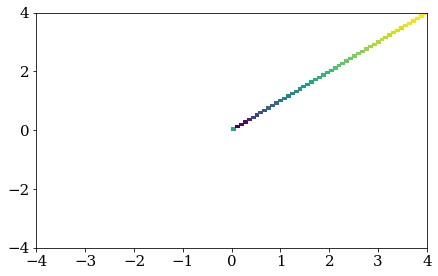

In [27]:
plt.hist2d(df_nu.MissingET_MET,df_nu.JB_MET,norm=mpl.colors.LogNorm(),bins=100, range=((-4,4),(-4,4)))
plt.show()

In [15]:
import ROOT
import collections
pdg = ROOT.TDatabasePDG()
l = list(set(df_hadrons.eval('GenHadron_PID')))
l.sort()
tot = len(df_hadrons)
for x in l:
    print(x,pdg.GetParticle(x).GetName(), 
          len(df_hadrons.query(f'GenHadron_PID=={x}'))/tot,sep='\t')

-3334	Omega+	1.179547542076525e-07
-3322	Xi0_bar	4.588439938677682e-05
-3312	Xi-_bar	2.5242317400437635e-05
-3222	Sigma+_bar	2.5124362646229983e-05
-3122	Lambda0_bar	0.0005586337159274422
-3112	Sigma-_bar	8.26862826995644e-05
-2212	antiproton	0.015986879656779973
-2112	antineutron	0.013060658114396531
-321	K-	0.02876586181812863
-211	pi-	0.22861848914822158
-13	mu+	6.180829120480991e-05
-11	e+	0.0017414839911217815
11	e-	0.0018832656056793798
13	mu-	0.00027801935566743697
22	gamma	0.42721454448174045
130	K_L0	0.02488680177125577
211	pi+	0.18601889375661948
310	K_S0	0.0020171442517050654
321	K+	0.028971221045204155
2112	neutron	0.01957164259190474
2212	proton	0.018878186591917954
3112	Sigma-	0.00023991997005836518
3122	Lambda0	0.0009237036802001268
3222	Sigma+	3.5150516753880443e-05
3312	Xi-	3.77455213464488e-05
3322	Xi0	7.089080727879915e-05


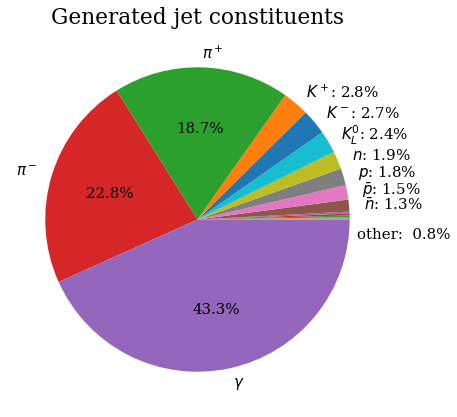

In [217]:

df = df_hadrons.query('GenJet_PT>10 and Gen_Q2>100')
l = list(set(df_hadrons.eval('GenHadron_PID')))
tot = len(df)
results = []
for x in l:
    results.append({'pid':x,'name':pdg.GetParticle(x).GetName(), 'frac':
          len(df.query(f'GenHadron_PID=={x}'))/tot})
#print(results)    
results.sort(key=lambda a: a['frac'])

fig,axs = plt.subplots(1,1,figsize=(7,7))

fracs = [r['frac'] for r in results]

latex_names = {211:'$\\pi^+$',-211:'$\\pi^-$',-2112:'$\\bar n$',2112:'$n$',
              321:'$K^+$',-321:'$K^-$',-2212:'$\\bar p$',2212:'$p$',
              22:'$\\gamma$',130:'$K^0_L$', 310:'$K^0_S$', 11: '$e^-$', -11: '$e^+$',
              3122:'$\\Lambda_0$',-3122:'$\\bar\\Lambda_0$',13:'$\\mu^-$',
               -3112:'$\\bar\\Sigma$', 3322:'$\\Xi_0$',-13:'$\\mu^+$', -3322:'$\\bar\\Xi_0$',
              3322:'$\\Xi^-$',-3322:'$\\bar\\Xi^-$',3222:'$\\Sigma^+$',-3222:'$\\bar\\Sigma^+$'}



common_types=[211,-211,-2112,2112,321,-321,-2212,2212,22,130]

labels = []

tot_others = 0

for r in results:
    if r['pid'] not in common_types:
        labels.append('')
        tot_others+= r['frac']
    elif r['frac']>.05:
        labels.append(latex_names[r['pid']])
    else :
        labels.append(f"{latex_names[r['pid']]}: {r['frac']*100:.1f}%")
#names = [r['name'] for r in results]
autopct = lambda x: ('%.1f%%'%x if x>5 else '')
plt.pie(fracs, labels=labels,autopct=autopct)


txt = f'other:  {tot_others*100:.1f}%'
# results.sort(key=lambda a: -a['frac'])
# for r in results:
#     if r['pid'] not in common_types:
#         print(f"\n{r['name']} {r['pid']}:  {r['frac']*100:.2f}")

plt.text(0.92,0.45, txt, transform=axs.transAxes)

#txt = ''
#for r in results:
#    if r['pid'] not in latex_names.keys():
#        txt+=f"{r['name']} {r['frac']*100:.2f}%\n"
#plt.text(0.8,0.2, txt, transform=axs.transAxes)
axs.set_title("Generated jet constituents")
plt.savefig("images/constituents.png")
plt.show()

Help on TParticlePDG in module __main__ object:

class TParticlePDG(TNamed)
 |  cppyy object proxy (internal)
 |  
 |  Method resolution order:
 |      TParticlePDG
 |      TNamed
 |      TObject
 |      CPPInstance
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  AddDecayChannel(...)
 |      int TParticlePDG::AddDecayChannel(int Type, double BranchingRatio, int NDaughters, int* DaughterPdgCode)
 |  
 |  AntiParticle(...)
 |      TParticlePDG* TParticlePDG::AntiParticle()
 |      const TParticlePDG* TParticlePDG::AntiParticle()
 |  
 |  Beauty(...)
 |      int TParticlePDG::Beauty()
 |  
 |  Charge(...)
 |      double TParticlePDG::Charge()
 |  
 |  Charm(...)
 |      int TParticlePDG::Charm()
 |  
 |  Class(...)
 |      static TClass* TParticlePDG::Class()
 |  
 |  Class_Name(...)
 |      static const char* TParticlePDG::Class_Name()
 |  
 |  Class_Version(...)
 |      static short TParticlePDG::Class_Version()
 |  
 |  DecayChannel(...)
 |      TDecayChannel* TParticle

In [208]:
len(df_hadrons.query("Hadron_P>=0"))/len(df_hadrons)

1.0

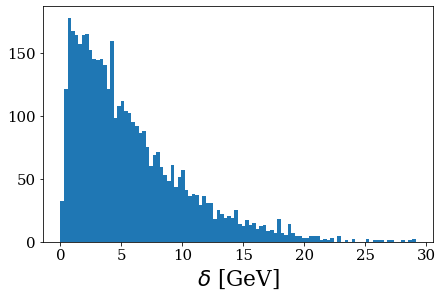

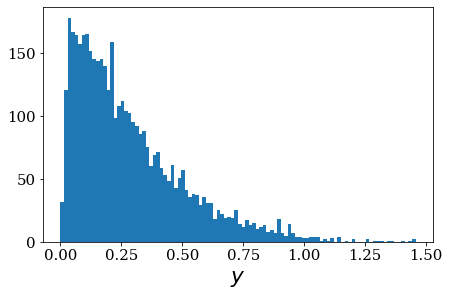

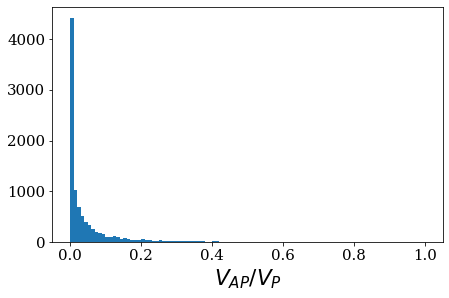

In [107]:
plt.hist(df_nu.JB_delta, bins=100); plt.gca().set_xlabel("$\\delta$ [GeV]")
plt.show()
plt.hist(df_nu.JB_y, bins=100); plt.gca().set_xlabel("$y$")
plt.show()

plt.hist(df_nu.VAP/df_nu.VP, bins=100, range=(0,1)); plt.gca().set_xlabel("$V_{AP}/V_P$")
plt.show()

In [95]:
30/(2*27.5)

0.5454545454545454

In [152]:
np.min(df_jets.Gen_Q2)

49.99386692989624